# Forecasting Exercise
This exercise walks through a SARIMA prediction and forecast similar to the one done on the Mauna Loa CO₂ dataset.<br>
This time we're using a seasonal time series of California Hospitality Industry Employees.

In [1]:
# RUN THIS CELL
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('../Data/HospitalityEmployees.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS'
print(len(df))
print(df.head())

348
            Employees
Date                 
1990-01-01     1064.5
1990-02-01     1074.5
1990-03-01     1090.0
1990-04-01     1097.4
1990-05-01     1108.7


So <tt>df</tt> has 348 records and one column. The data represents the number of employees in thousands of persons as monthly averages from January, 1990 to December 2018.

### 1. Plot the source data
Create a line chart of the dataset. Optional: add a title and y-axis label.

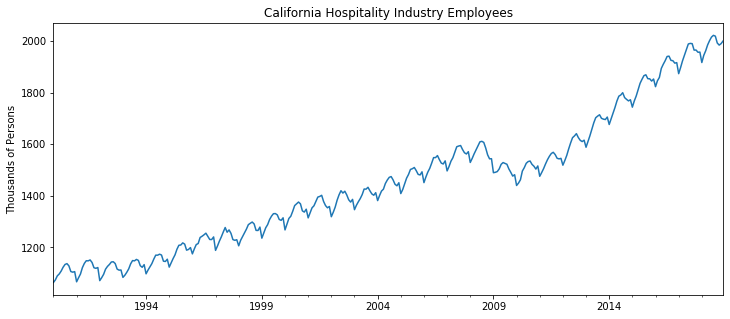

In [2]:
title='California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel='' # we don't really need a label here

ax = df['Employees'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### 2. Run an ETS Decomposition
Use an 'additive' model.

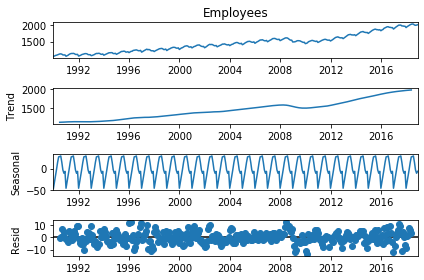

In [3]:
result = seasonal_decompose(df['Employees'], model='add')
result.plot();

### 3. Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot of combinations to evaluate.

In [4]:
auto_arima(df['Employees'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  348
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 12)   Log Likelihood               -1098.110
Date:                            Fri, 17 Jul 2020   AIC                           2216.221
Time:                                    18:52:02   BIC                           2254.714
Sample:                                         0   HQIC                          2231.547
                                            - 348                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.010      0.115      0.909      -0.018       0.020
ar.L1          1.0926      0.038     28.645      0.000       1.018       1.167
ar.L2         -0.1658      0.033     -5.051      0.000      -0.230      -0.101
ma.L1         -1.1194      0.060    -18.617      0.000      -1.237      -1.002
ma.L2          0.2878      0.069      4.191      0.000       0.153       0.422
ar.S.L12       0.0169      0.068      0.248      0.804      -0.116       0.150
ar.S.L24       0.9779      0.068     14.483      0.000       0.846       1.110
ma.S.L12       0.2251      0.088      2.567      0.010       0.053       0.397
ma.S.L24      -0.7401      0.067    -11.081      0.000      -0.871      -0.609
sigma2        29.0869      1.703     17.081      0.000      25.749      32.425
===================================================================================
Ljung-Box (Q):                       30.85   Jarque-Bera (JB):                63.80
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.12
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

You should see a recommended ARIMA Order of (0,1,0) combined with a seasonal order of (2,0,0,12).
### 4. Split the data into train/test sets
Set one year (12 records) for testing. There is more than one way to do this!

In [5]:
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

### 5. Fit a SARIMA(0,1,0)(2,0,0,12) model to the training set

In [6]:
model = SARIMAX(train['Employees'],order=(0,1,0),seasonal_order=(2,0,0,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Employees   No. Observations:                  336
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -1095.407
Date:                            Fri, 17 Jul 2020   AIC                           2196.814
Time:                                    18:52:02   BIC                           2208.256
Sample:                                01-01-1990   HQIC                          2201.375
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5204      0.040     13.051      0.000       0.442       0.599
ar.S.L24       0.4385      0.041     10.593      0.000       0.357       0.520
sigma2        37.1907      2.165     17.175      0.000      32.947      41.435
===================================================================================
Ljung-Box (Q):                      102.79   Jarque-Bera (JB):                56.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.35
Prob(H) (two-sided):                  0.74   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 6. Obtain predicted values

In [7]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,0)(2,0,0,12) Predictions')

### 7. Plot predictions against known values
Optional: add a title and y-axis label.

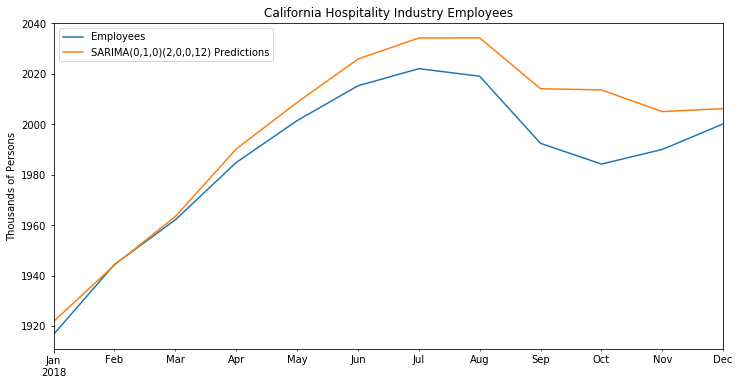

In [8]:
title='California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''

ax = test['Employees'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### 8. Evaluate the Model using MSE and RMSE
You can run both from the same cell if you want.

In [9]:
error1 = mean_squared_error(test['Employees'], predictions)
error2 = rmse(test['Employees'], predictions)
print(f'SARIMA(0,1,0)(2,0,0,12) MSE Error: {error1:11.10}')
print(f'SARIMA(0,1,0)(2,0,0,12) RMSE Error: {error2:11.10}')

SARIMA(0,1,0)(2,0,0,12) MSE Error: 182.8472951
SARIMA(0,1,0)(2,0,0,12) RMSE Error: 13.52210394


### 9. Retrain the model on the full data and forecast one year into the future

In [10]:
model = SARIMAX(df['Employees'],order=(0,1,0),seasonal_order=(2,0,0,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,1,0)(2,0,0,12) Forecast')

### 10. Plot the forecasted values alongside the original data
Optional: add a title and y-axis label.

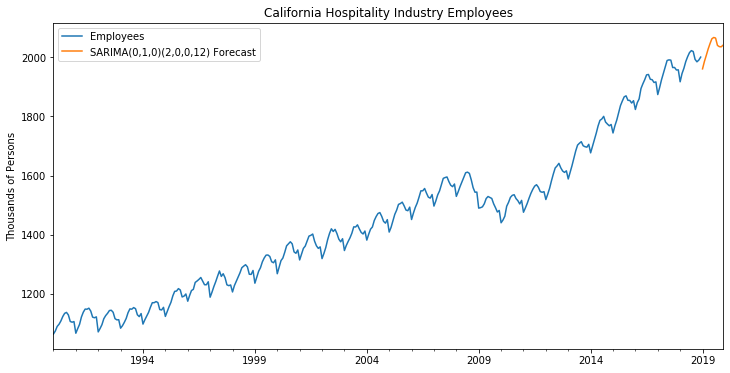

In [11]:
title='California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''

ax = df['Employees'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

----

----